### Setup

In [1]:
import os
import sys
import datetime
import calendar
import itertools
import math
import time

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.stats.stattools as smss
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model, unitroot
import warnings
warnings.warn = lambda *a, **kw: False
warnings.filterwarnings("ignore")

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset, NyseFundamentalsDataset
import src.econometric_utils as eco
import src.regression_utils as regr
import src.plot_utils as plot
import src.math_utils as math_utils
import src.utils as utils

import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html
import visJS2jupyter
import visJS2jupyter.visJS_module as visJS_module
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/


get_month = lambda i: datetime.date(2000, int(i), 1).strftime('%B')
get_weekday = lambda i: calendar.day_name[int(i)]
split = lambda x: (x.iloc[:600], x.iloc[600:])  # train: 2010-01-05 until 2012-05-21, val: 2012-05-21 until 2012-12-31

TRAIN_FRAME = pd.to_datetime('2010-01-05'), pd.to_datetime('2012-05-21')
VAL_FRAME = pd.to_datetime('2012-05-22'), pd.to_datetime('2012-12-31')

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True, look_back=1)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)
fundamentals = NyseFundamentalsDataset(file_path='../data/nyse/fundamentals.csv', load=True)


time: 8.01 s


In [3]:
gspc = stocks.load_gspc().set_index('date')[['gspc_open', 'gspc_close']].rename(lambda x: x.replace('gspc_', ''), axis=1)
gspc = eco.add_movements(gspc)

vix = stocks.load_vix().set_index('date')[['vix_open', 'vix_close']].rename(lambda x: x.replace('vix_', ''), axis=1)
vix = eco.add_movements(vix)

prices = stocks.enhance_features(stocks.prices.copy())
comp_metas, train_comp_prices, val_comp_prices = [], [], []
comp_grouped = prices.groupby(prices.symbol, sort=False)
for sym, p in tqdm(comp_grouped):
    if not stocks.is_company_available(sym):
        continue
    train, val = split(eco.add_movements(p).drop(columns=['symbol', 'movement']).set_index('date'))
    assert train.index.min() == TRAIN_FRAME[0] and train.index.max() == TRAIN_FRAME[1], f'Shape not matching for {sym}'
    assert val.index.min() == VAL_FRAME[0] and val.index.max() == VAL_FRAME[1], f'Shape not matching for {sym}'
    train_comp_prices.append(train)
    val_comp_prices.append(val)
    comp_metas.append({'symbol': sym, 'industry': securities.get_industry(sym), 'name': securities.get_company_name(sym)})

comp_metas = pd.DataFrame(comp_metas)


time: 2min 17s


### Select Industry

In [4]:
def get_industry(ind_name, val=False):
    indizes = comp_metas.index[comp_metas.industry == ind_name]
    for i in indizes:
        _, name, symbol = comp_metas.iloc[i]
        if val:
            yield symbol, name, val_comp_prices[i]
        else:
            yield symbol, name, train_comp_prices[i]

all_industries = comp_metas.industry.unique()
print('Industries:', ', '.join(all_industries))

Industries: Health Care, Industrials, Consumer Discretionary, Information Technology, Consumer Staples, Utilities, Financials, Materials, Real Estate, Energy, Telecommunications Services
time: 174 ms


In [5]:
# Calculate movements per industry to normalize stock prices
ind_means = pd.DataFrame([pd.DataFrame([p.boxcox for _, _, p in get_industry(i)]).mean() for i in all_industries], index=all_industries).T
# (ind_means.T - gspc.boxcox[ind_means.index]).T.corr()

pd.Series([len(list(get_industry(x))) for x in all_industries], index=all_industries)

Health Care                    54
Industrials                    63
Consumer Discretionary         77
Information Technology         63
Consumer Staples               34
Utilities                      28
Financials                     58
Materials                      23
Real Estate                    29
Energy                         33
Telecommunications Services     5
dtype: int64

time: 654 ms


In [6]:
# e.g. greatest energy companies: XOM, CHK
industry_name = 'Energy'  # 'Information Technology'
industry = list(get_industry(industry_name))
industry_val = list(get_industry(industry_name, val=True))
greatest_comp = np.argmax([(p.volume.max()) for _, _, p in industry])
(symbol, name, price), val_price = industry[greatest_comp], industry_val[greatest_comp][2]

time: 247 ms


Shapiro test (null=normal): p value = 0.0020
Shapiro test (null=normal): p value = 0.0026
Shapiro test (null=normal): p value = 0.4177

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9380
>Mann-Whitney (null = equal): p value = 0.4690

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9060
>Mann-Whitney (null = equal): p value = 0.4530


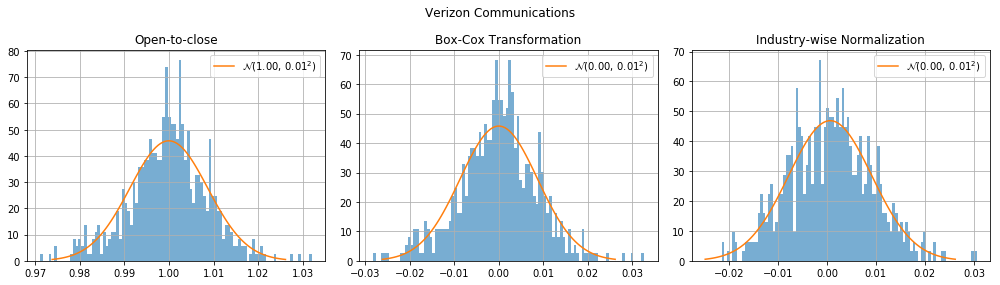

time: 2.78 s


In [646]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot.compare_with_normal(price.otc, 'Open-to-close', ax=axes[0])
plot.compare_with_normal(price.boxcox, 'Box-Cox Transformation', ax=axes[1])
plot.compare_with_normal(price.boxcox - ind_means[securities.get_industry(sym)], 'Industry-wise Normalization', ax=axes[2])
fig.suptitle(securities.get_company_name(sym))
fig.tight_layout()
plt.subplots_adjust(top=0.83)
# fig.savefig(f'data-preprocessing-{sym}.pdf')

regr.compare_distributions(price.otc - 1, price.lret / 100)
regr.compare_distributions(price.boxcox, price.lret / 100)

### Regression Analysis

#### Distribution

In [892]:
# Using all at once (comp_orig_returns.stack()) -> nothing fits
math_utils.inspect_data_distributions(comp_prices.stack(), verbose=True);

norm            p: 0.0000 D: 0.0600
cauchy          p: 0.0000 D: 0.0509
chi             p: 0.0000 D: 0.3886
chi2            p: 0.0000 D: 0.2765
f               p: 0.0000 D: 0.4534
johnsonsb       p: 0.0000 D: 0.0600
laplace         p: 0.0000 D: 0.0198
logistic        p: 0.0000 D: 0.0232
maxwell         p: 0.0000 D: 0.4710
pareto          p: 0.0000 D: 0.5899
t               p: 0.0000 D: 0.0079
uniform         p: 0.0000 D: 0.4434
wald            p: 0.0000 D: 0.4618
time: 2min 1s


In [13]:
# Using all at once (comp_orig_returns.stack()) -> nothing fits
steps_pvalues = pd.DataFrame(index=math_utils.cdfs, columns=['returns', 'normed', 'resid'])
steps_pvalues2 = pd.DataFrame(index=math_utils.cdfs, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    pvalues = pd.DataFrame(index=math_utils.cdfs, columns=comp_symbols)
    for sym, comp_price in tqdm(values.iteritems(), total=len(comp_symbols)):
        pvalues[sym] = math_utils.inspect_data_distributions(comp_price)
    steps_pvalues[col_name] = (pvalues > 0.05).sum(axis=1)
    steps_pvalues2[col_name] = (pvalues > 0.5).sum(axis=1)


time: 4.06 s


In [94]:
steps_pvalues
# steps_pvalues2

,returns,normed,resid
norm,330,304,337
cauchy,17,16,11
chi,125,123,169
chi2,78,67,97
f,330,166,155
johnsonsb,340,310,354
laplace,423,417,398
logistic,467,467,467
maxwell,0,0,0
pareto,0,0,0


time: 239 ms


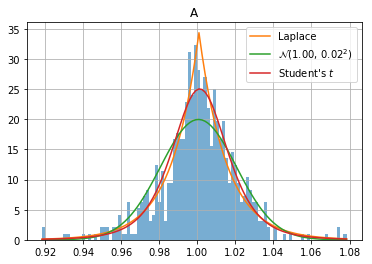

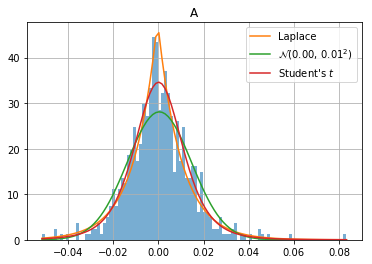

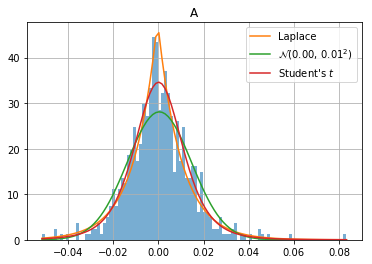

time: 2.11 s


In [10]:
plot.compare(comp_orig_returns['A'])
plot.compare(comp_prices['A'])
plot.compare(comp_resids['A']);

In [ ]:
dfs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
locs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
scales = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in values.iteritems():
        dfs.loc[sym, col_name], locs.loc[sym, col_name], scales.loc[sym, col_name] = stats.t.fit(comp_price)

Average parameters for Student's $t$:

|   -     |         df |          loc |      scale |
|:--------|-----------:|-------------:|-----------:|
| returns |    6.10691 |  1.00038     | 0.0128028  |
| normed  |    6.76845 | -0.000108763 | 0.00890573 |
| resid   |    6.91496 | -0.00554267  | 0.407496   |

For one resid series, the df was 2726813. The outlier was removed for taking the average

#### Characteristics

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.2056
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.9291
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.53

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Heteroscedastiscity:
>Engle's ARCH (null = homosc.): p value = 0.0022
>White (null = homosc.): p value = 0.0000
>Breusch-Pagan (null = homosc.): p value = 0.0074
>Goldfeld-Quandt (null = homosc.): p value = 0.0000
>Levene alias Brown-Forsythe (null = homosc.): p value = 0.0006
>Fligner-Killeen (null = homosc.): p value = 0.0031
>[DEV]Wald-Test on squares (null = homosc.): p value = 0.3377

Test for Structural Breaks:
>CUSUM test on 

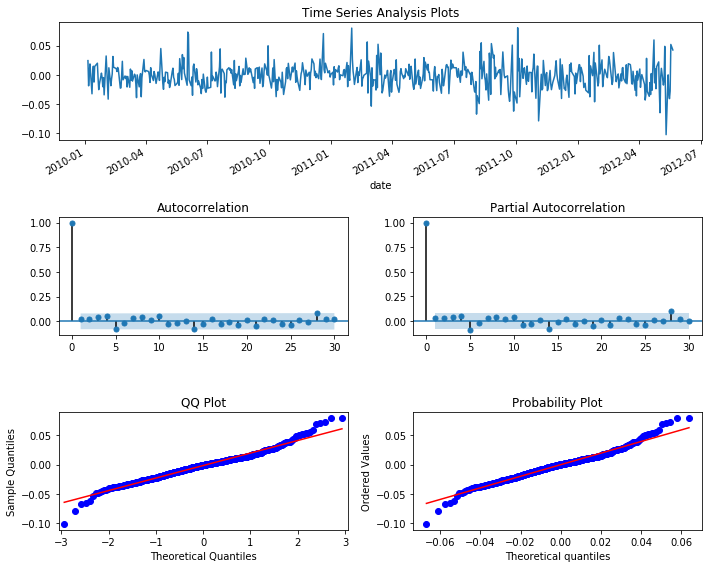

time: 1.63 s


In [108]:
plot.tsplot(price.boxcox);
regr.investigate(price.boxcox, verbose=True);

In [8]:
print(unitroot.ADF(price.boxcox).regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.39e-84
Time:                        17:36:03   Log-Likelihood:                 1446.6
No. Observations:                 595   AIC:                            -2881.
Df Residuals:                     589   BIC:                            -2855.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.9317      0.086    -10.797      0.0

#### Seasonality

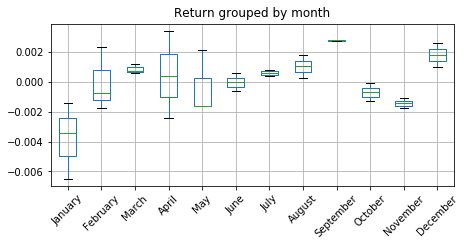

time: 514 ms


In [661]:
def plot_months(r, store_path=False, comp=False):
    if comp:
        monthly_returns = r.groupby([r.index.month.rename('month'), r.sym]).mean()
        monthly_returns = pd.DataFrame(monthly_returns.reset_index().values, columns=('month', 'sym', 'return'))
    else:
        monthly_returns = r.groupby([r.index.year.rename('year'), r.index.month.rename('month')]).mean()
        monthly_returns = pd.DataFrame(monthly_returns.reset_index().values, columns=('year', 'month', 'return'))
    fig, ax = plt.subplots(figsize=(7, 3))
    ax = monthly_returns.boxplot(column='return', by='month', ax=ax)
    fig.suptitle('Return grouped by month')
    ax.set_title('')
    ax.set_xlabel('')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    plt.xticks(monthly_returns.month.unique(), [get_month(x) for x in monthly_returns.month.unique()], rotation=45)
    plt.tick_params(axis='both', which='major')
    if store_path is not False:
        fig.savefig(store_path)
    return monthly_returns

plot_months(price.boxcox);  # [price.index.year == 2010]

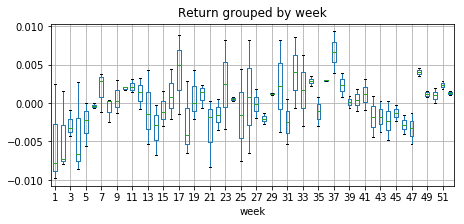

time: 1.29 s


In [662]:
def plot_weeks(r, store_path=False, comp=False):
    if comp:
        weekly_returns = r.groupby([r.index.week.rename('week'), r.sym]).mean()
        weekly_returns = pd.DataFrame(weekly_returns.reset_index().values, columns=('week', 'sym', 'return'))
    else:
        weekly_returns = r.groupby([r.index.year.rename('year'), r.index.week.rename('week')]).mean()
        weekly_returns = pd.DataFrame(weekly_returns.reset_index().values, columns=('year', 'week', 'return'))
    fig, ax = plt.subplots(figsize=(7, 3))
    ax = weekly_returns.boxplot(column='return', by='week', ax=ax)
    fig.suptitle('Return grouped by week')
    ax.set_title('')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    plt.xticks(weekly.week.unique()[::2], [int(x) for x in weekly.week.unique()[::2]])
    plt.tick_params(axis='both', which='major')
    if store_path is not False:
        fig.savefig(store_path)
    return weekly_returns

plot_weeks(price.boxcox);

There is no consistent shape over the years for weekdays

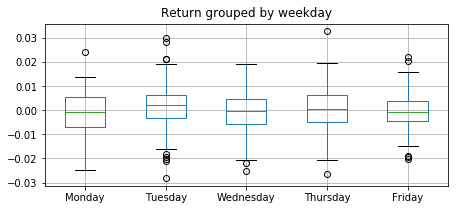

time: 386 ms


In [663]:
def plot_weekdays(r, store_path=False, comp=False):
    if comp:
        daily_returns = r.groupby([r.index.weekday.rename('weekday'), r.sym]).mean()
        daily_returns = pd.DataFrame(daily_returns.reset_index().values, columns=('weekday', 'sym', 'return'))
    else:
        daily_returns = r.rename('return').reset_index().rename_axis({'date': 'weekday'}, axis=1)
        daily_returns.weekday = daily_returns.weekday.dt.weekday
    fig, ax = plt.subplots(figsize=(7, 3))
    ax = daily_returns.boxplot(column='return', by='weekday', ax=ax)
    fig.suptitle('Return grouped by weekday')
    ax.set_title('')
    ax.set_xlabel('')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    plt.xticks(daily_returns.weekday.unique() + 1, [get_weekday(x) for x in daily_returns.weekday.unique()])
    plt.tick_params(axis='both', which='major')
    if store_path is not False:
        fig.savefig(store_path)
    return daily_returns

plot_weekdays(price.boxcox);

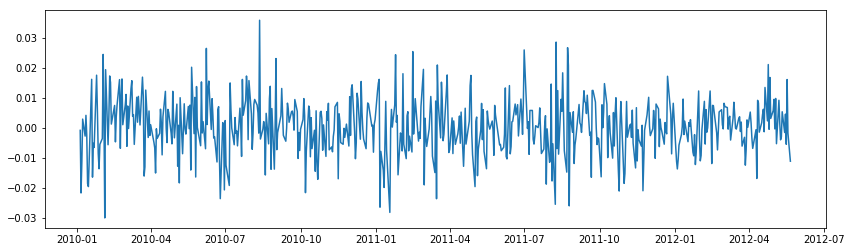

time: 2.94 s


In [486]:
a = smt.SARIMAX(price.boxcox, order=(3, 0, 2), seasonal_order=(0, 1, 1, 12))
f = a.fit(trend='nc', update_freq=5)
plt.subplots(figsize=(14, 4))
plt.plot(f.resid);

- https://medium.com/@a.nejad_99199/exploring-market-seasonality-trends-19a91381c0fe
- https://github.com/anejad/Exploring-Market-Seasonality-Trends/blob/master/Exploring%20Seasonality%20Trends%20in%20Stock%20Market.ipynb
- https://otexts.com/fpp2/components.html
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
- https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2030&context=jmasm

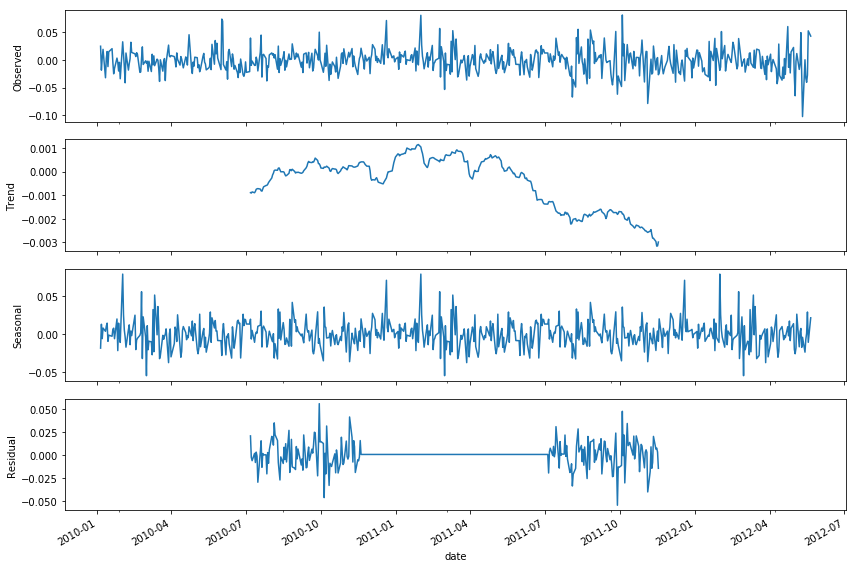

time: 810 ms


In [14]:
regr.inspect_seasonality(price.boxcox);

In [666]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries])  # all_industries[3], all_industries[-2], all_industries
r = pd.concat([price.boxcox - ind_means[securities.get_industry(sym)] for sym, _, price in comps])
symbols = pd.concat([pd.Series([sym]*len(price)) for sym, _, price in comps])
merged = pd.concat([r.reset_index(drop=True), symbols.reset_index(drop=True)], axis=1)
merged.index = r.index
merged.columns = ['return', 'sym']

time: 1.22 s


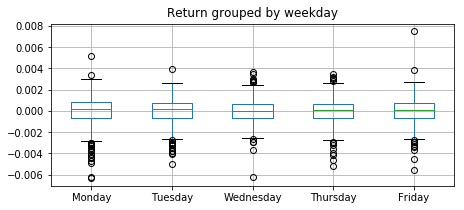

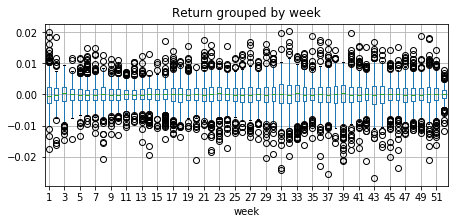

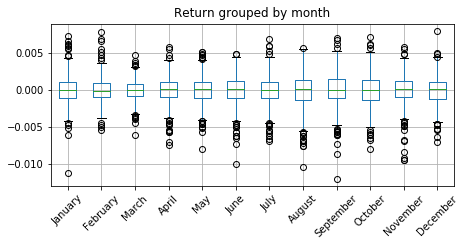

time: 3.25 s


In [667]:
# ry = merged[merged.index.year == 2011]
plot_weekdays(merged, 'returns-per-weekday.pdf', comp=True);
plot_weeks(merged, 'returns-per-week.pdf', comp=True);
plot_months(merged, 'returns-per-month.pdf', comp=True);

#### Develop & Fit ARIMA

In [ ]:
_, arima_params = regr.get_best_arima(price.boxcox)
model = smt.ARIMA(price.boxcox, order=arima_params)
model_fit = model.fit(method='mle', trend='nc', update_freq=5)
in_sample_predictions = model_fit.predict()

print(model_fit.summary())

In [ ]:
ex_sample_predictions = regr.predict_rolling_forward(price.boxcox, val_price.boxcox, arima_params)

In [ ]:
regr.is_autocorrelated(price.boxcox, verbose=True);
# After ARIMA modelling the autocorrelation is completely gone
regr.is_autocorrelated(model_fit.resid, verbose=True);

In [ ]:
regr.plot_arima_predictions(price.boxcox, val_price.boxcox, arima_params)

#### Develop & fit GARCH

In [ ]:
arima_residuals = regr.ARIMA_GARCH(price.boxcox, *arima_params, 1, 1).arima_fit.resid
_, garch_params = regr.get_best_garch(arima_residuals)
plot.tsplot(arima_residuals**2);

In [ ]:
# Result from last block: PACF is considerable until lag=5
garch_params = (5, 5) # p = lagged variance, q = lagged residuals
model = regr.ARIMA_GARCH(price.boxcox, *arima_params, *garch_params, vol_model='GARCH')
print(model.garch_fit.summary())

In [ ]:
ex_sample_predictions = regr.plot_garch_predictions(price.boxcox, val_price.boxcox, arima_params, garch_params, vol_model='GARCH')

#### Skewness and Kurtosis

-0.9978896450053656
1.317961281048357


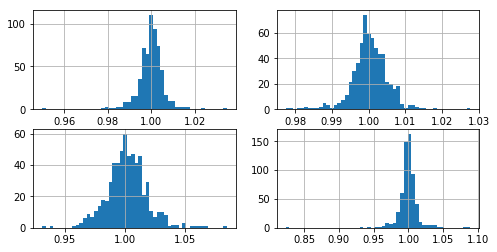

time: 5.49 s


In [295]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries]) 
key = 'cto'
skewness = [smss.robust_skewness(price[key])[-1] for sym, _, price in comps]
# skewness = [smss.robust_skewness(regr.model_GARCH(regr.model_ARMA(price[key] - ind_means[securities.get_industry(sym)])[0])[0])[-1] for sym, _, price in comps]
print(pd.Series(skewness).mean())
kurtosis = [smss.robust_kurtosis(price[key])[-1] for sym, _, price in comps]
# kurtosis = [smss.robust_kurtosis(regr.model_GARCH(regr.model_ARMA(price[key] - ind_means[securities.get_industry(sym)])[0])[0])[-1] for sym, _, price in comps]
print(pd.Series(kurtosis).mean())
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
comps[np.argmin(skewness)][2][key].hist(bins=50, ax=axes[0, 0])
comps[np.argmax(skewness)][2][key].hist(bins=50, ax=axes[0, 1])
comps[np.argmin(kurtosis)][2][key].hist(bins=50, ax=axes[1, 0])
comps[np.argmax(kurtosis)][2][key].hist(bins=50, ax=axes[1, 1]);

Skewness and Kurtosis of data:
- For ctc   :  skewness =  0.007, kurtosis = 0.811, os = -0.0570, ok =  4.9078
- For oto   :  skewness = -0.404, kurtosis = 0.672, os = -0.0676, ok =  4.2531
- For cto   :  skewness = -0.998, kurtosis = 1.318, os = -0.0610, ok = 14.9623
- For otc   :  skewness = -0.129, kurtosis = 0.590, os =  0.0611, ok =  2.5132
- For boxcox:  skewness = -0.320, kurtosis = 0.586, 
- For normed:  skewness =  1.377, kurtosis = 0.565, os =  0.1114, ok =  3.1895
- For arma  :  skewness =  1.347, kurtosis = 0.563, 
- For garch :  skewness =  0.821, kurtosis = 0.500, os =  0.1088, ok =  2.8641

Much higher kurtosis and different skewness for not-robust estimations (outlier have a big impact).

In [29]:
kurtosis = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
skewness = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in values.iteritems():
        kurtosis.loc[sym, col_name] = stats.kurtosis(comp_price)
        skewness.loc[sym, col_name] = stats.skew(comp_price)
# print(kurtosis.mean())

time: 3.23 s


#### Inspect Transformations

In [23]:
comps = np.concatenate([list(get_industry(x)) for x in all_industries])
comp_symbols = [x[0] for x in comps]

chars = pd.DataFrame(index=comp_symbols, columns=pd.MultiIndex.from_product(
    [['orig', 'otc', 'boxcox', 'normed', 'resid', 'std_resid'],
     ['unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks', 'outliers']]))

models_params = pd.DataFrame(np.nan, columns=['p', 'q', 'r', 's'], index=comp_symbols)

for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    resid, p, q = regr.model_ARMA(normed)
    std_resid, r, s = regr.model_GARCH(resid)
    
    chars.loc[sym].orig = regr.investigate(orig)
    chars.loc[sym].otc = regr.investigate(otc)
    chars.loc[sym].boxcox = regr.investigate(boxcox)
    chars.loc[sym].normed = regr.investigate(normed)
    models_params.loc[sym] = (p, q, r, s)
    if p != 0 or q != 0:
        chars.loc[sym].resid = regr.investigate(resid)
    if r != 0 or s != 0:
        chars.loc[sym].std_resid = regr.investigate(std_resid)

has_arma_applied = (models_params.p != 0) | (models_params.q != 0)
has_garch_applied = (models_params.r != 0) | (models_params.s != 0)
print('Applied ARMA models:', sum(has_arma_applied))
print('Applied GARCH models:', sum(has_garch_applied))


Applied ARMA models: 66
Applied GARCH models: 228
time: 6min 28s


In [158]:
t = chars.T
t.index = t.index.swaplevel()
# ur = t.loc['unit_root']
# ur = t.loc['autocorr']
# ur = t.loc['normal_dist']
# ur = t.loc['heteroscedastic']
# ur = t.loc['breaks']
ur = t.loc['outliers']

ur = ur.fillna(method='ffill')

# Inspect the amount of changes between each transformation step
all_hits = set()
prev = set()
for x in ['orig', 'otc', 'boxcox', 'normed', 'resid', 'std_resid']:  # 
    target = ur # ur.loc[:, has_garch_applied]
    hits = set(target.columns[target.loc[x] > 3])
    print(len(hits), len(hits - prev), len(prev - hits))
    prev = hits
    all_hits = all_hits.union(prev)

13 13 0
129 126 10
134 41 36
163 109 80
162 4 5
163 39 38
time: 431 ms


__Unit Root:__
- Orig, 9 without UR: `['HBAN', 'HBI', 'KEY', 'LEG', 'MTB', 'PEG', 'RSG', 'SYY', 'YHOO']`
    - Did not became worse in any step
- OTC didn't work, 8 left with UR: `['FSLR', 'FTR', 'GILD', 'INTC', 'NFLX', 'PFE', 'SIG', 'STX']`
- Box-Cox didn't change anything
- Normed only made it worse, 26: `['ADBE', 'EQIX', 'FE', 'FOX', 'ILMN', 'KMB', 'MON', 'MSFT', 'NFX', 'PCAR', 'RRC', 'SPG', 'UPS', 'V', 'WDC', 'WMT', 'WYNN', 'XOM']`
- ARMA fixed for one company out of eight where it was applied
- GARCH fixed one comp and unfixed one comp (out of 18 applications)

--> Finally 23 stocks still do not satisfy the KPSS test

__Auto Correlation:__
- All are totally auto-correlated
- After OTC all still have at least one significant test result for auto-correlation
- After Box-Cox only 104 still have significance (50x 1.0, 54x 0.5)
- After Normalization only 67 still have significance (39x 1.0, 28x 0.5)
- After ARMA only 2 have significance
- After GARCH only 7 have significance

__Normal Distribution:__
- Initially 35 reveal evidence for norm. (at least 1 out of 4 tests)
- 22 OTC returns indicate norm.
- Box-Cox Transformation adds 8 and removes 2
- Normalization adds 20 and removes 25 (->23). It has a huge impact since it changes the data properties in a drastic way. While the combination of an industrial mean and a stocks individual moves, revealed evidenve for the existence/absence of a norm., it switched after extracting the individual behaviour.
- Taking ARMA residuals and GARCH residuals lead to 18 more normal distributions (ARMA: +-0, GARCH: +19-1) --> Finally 41

__Heteroscedasticity:__
- 386 (122 twice) OTC returns are heteros.
- Box-Cox made it much worse: 429 (303 twice) heteros.
- Normalization fixed many: 243 heteros (75 twice, 155 White over BP, 13 BP over White) heteros.
- After ARMA modelling 240 remain (73 twice)
- After GARCH 125 (25 twice, 81 White over BP, 19 BP over White) stock prices remain which do not satify our test for homoscedasticity

__Structural Breaks:__
- Only 9 of all original prices are assumed to contain at least one structural break
- Before transformation and normalization 6 show evidence, afterwards 12.
- The number does not change much between the steps of transformations except for the normalization step. Eventhough, we are trying to remove the mean movement across one industry, not all prices might contain this overall behaviour for the entire period. Therefore for some periods of stock prices, the normalization step appears to introduce a new movement which leads to the significant rejection of stable coefficients over the entire times series.
- After ARMA & GARCH: 11

##### ACF

In [150]:
lag_acf = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
lag_acf_resid = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
is_ac = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
is_ac_resid = pd.DataFrame(columns=np.arange(10), index=comp_prices.columns)
for sym, ts in tqdm(comp_prices.iteritems()):
    acf_vals, confint = smt.acf(ts, nlags=len(lag_acf.columns), alpha=0.05)
    acf_vals, confint = acf_vals[1:], confint[1:]
    is_ac.loc[sym] = sms.acorr_ljungbox(ts, lags=10)[1] <= 0.05
    lag_acf.loc[sym] = acf_vals
    ts, p, q = regr.model_ARMA(ts)
    if p | q:
        acf_vals, confint = smt.acf(ts, nlags=len(lag_acf.columns), alpha=0.05)
        acf_vals, confint = acf_vals[1:], confint[1:]
        lag_acf_resid.loc[sym] = acf_vals
        is_ac_resid.loc[sym] = sms.acorr_ljungbox(ts, lags=10)[1] <= 0.05

# lag_acf[~(lag_acf == lag_acf_resid).all(axis=1)].shape
print("AC before:", is_ac[is_ac.any(axis=1)].shape[0])
print("ARMA, AC before:", is_ac[is_ac_resid.notna().any(axis=1)].shape[0])
print("ARMA applied:", is_ac_resid[is_ac_resid.notna().any(axis=1)].shape[0])
print("Still AC after modelling:", is_ac_resid[is_ac_resid.any(axis=1)].shape[0])

print("\nONLY FIRST LAG:")
# lag_acf[~(lag_acf == lag_acf_resid).all(axis=1)].shape
print("AC before:", is_ac[is_ac[0]].shape[0])
print("ARMA, AC before:", is_ac[is_ac_resid.notna()[0]].shape[0])
print("ARMA applied:", is_ac_resid[is_ac_resid.notna()[0]].shape[0])
print("Still AC after modelling:", is_ac_resid[is_ac_resid[0].fillna(False)].shape[0])

AC before: 161
ARMA, AC before: 66
ARMA applied: 66
Still AC after modelling: 4

ONLY FIRST LAG:
AC before: 66
ARMA, AC before: 66
ARMA applied: 66
Still AC after modelling: 1
time: 316 ms


##### Outliers

In [93]:
dfs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
locs = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
scales = pd.DataFrame(index=comp_symbols, columns=['returns', 'normed', 'resid'])
for col_name, values in zip(steps_pvalues.columns, [comp_orig_returns, comp_prices, comp_resids]):
    for sym, comp_price in valu<es.iteritems():
        dfs.loc[sym, col_name], locs.loc[sym, col_name], scales.loc[sym, col_name] = stats.t.fit(comp_price)

time: 55.5 s


Average parameters for Student's $t$:

|   -     |         df |          loc |      scale |
|:--------|-----------:|-------------:|-----------:|
| returns |    6.10691 |  1.00038     | 0.0128028  |
| normed  |    6.76845 | -0.000108763 | 0.00890573 |
| resid   |    6.91496 | -0.00554267  | 0.407496   |

For one resid series, the df was 2726813. The outlier was removed for taking the average

In [152]:
outliers = []

for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    outliers.append(normed.iloc[regr.get_outliers(normed)])
    
outliers = pd.concat([x.reset_index(drop=True) for x in outliers], axis=1)


time: 36.7 s


Expected outliers: 3.0 (vs. 5)


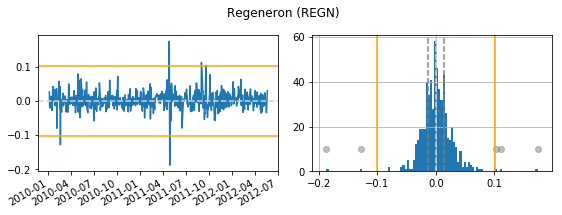

time: 1.36 s


In [153]:
sym, name, price = comps[outliers.max().idxmax()]
# sym, name, price = comps[(outliers.notna().sum() == outliers.shape[0]).idxmax()]
price = price.boxcox - ind_means[securities.get_industry(sym)]
regr.get_outliers(price, debug=True);
fig = plt.gcf()
fig.suptitle(f'{name} ({sym})')
fig.tight_layout()
plt.subplots_adjust(top=0.85)
# fig.savefig(f'data-outliers-{sym}.pdf')

KS-test result: Best result for Student's t with 0.84 and only 0.16 for norm.

- https://finance.yahoo.com/quote/REGN/history?period1=1303250400&period2=1304200800&interval=1d&filter=history&frequency=1d
- https://newsroom.regeneron.com/news-releases/news-release-details/regeneron-and-bayer-report-positive-results-vegf-trap-eye-second/
- https://newsroom.regeneron.com/node/18236/html
- https://investor.regeneron.com/financial-information?field_nir_sec_form_group_target_id%5B476%5D=476&field_nir_sec_date_filed_value=2011&items_per_page=10&page=2

##### Compare HET tests

In [319]:
het_stats = pd.DataFrame(index=comp_symbols, columns=['white', 'bp'])
het_stats2 = pd.DataFrame(index=comp_symbols, columns=['white', 'bp'])
for sym, _, price in tqdm(comps):
    orig, otc, boxcox = price.open, price.otc, price.boxcox
    normed = boxcox - ind_means[securities.get_industry(sym)]
    resid, p, q = regr.model_ARMA(normed)
    std_resid, r, s = regr.model_GARCH(resid)
    ts, exog = regr.get_auto_lags(normed)
    het_stats.loc[sym] = sms.het_white(ts, exog)[1] <= 0.05, sms.het_breuschpagan(ts, exog)[1] <= 0.05
    ts, exog = regr.get_auto_lags(std_resid)
    het_stats2.loc[sym] = sms.het_white(ts, exog)[1] <= 0.05, sms.het_breuschpagan(ts, exog)[1] <= 0.050


time: 1min 55s


### Correlate Industry-wise

#### Setup

In [7]:
def calc_residuals_v2(industries=all_industries, norm_gspc=False, return_all=False):
    global temp_resid
    comps = np.concatenate([list(get_industry(x)) for x in industries]) 
    comp_symbols = [x[0] for x in comps]
    comp_chars = pd.DataFrame(
        index=comp_symbols, columns=[
        'p', 'q', 'r', 's', 'unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks', 'outliers'])
    comp_resid_chars = pd.DataFrame(comp_chars)
    comp_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in comps]).T
    comp_orig_returns = pd.DataFrame([x[2].otc.rename(x[0]) for x in comps]).T
    if norm_gspc:
        comp_prices = pd.DataFrame([(x[2].boxcox - gspc.boxcox[x[2].index]).rename(x[0]) for x in comps], index=comp_symbols).T
    else:
        comp_prices = pd.DataFrame([(x[2].boxcox - ind_means[securities.get_industry(x[0])]).rename(x[0]) for x in comps], index=comp_symbols).T
    comp_resids = pd.DataFrame(index=comp_prices.index, columns=comp_symbols)
    
    # Apply ARIMA and take residuals
    for symbol, comp_name, _ in tqdm(comps):
        comp_price = comp_prices[symbol].copy()
        resid, p, q = regr.model_ARMA(comp_price)
        std_resid, r, s = regr.model_GARCH(resid)
        comp_resids.loc[:, symbol] = std_resid
        comp_chars.loc[symbol] = (p, q, r, s, *regr.investigate(comp_price))
        comp_resid_chars.loc[symbol] = (p, q, r, s, *regr.investigate(std_resid))
        time.sleep(0.5)
    
    print('Are the characteristics the same as before?', all(comp_resid_chars == comp_chars))
    return comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars

        
def calc_residuals(industries=all_industries, norm_gspc=False):
    comps = np.concatenate([list(get_industry(x)) for x in industries]) 
    comp_symbols = [x[0] for x in comps]
    comp_chars = pd.DataFrame(
        index=comp_symbols, columns=[
        'arima_p', 'arima_d', 'arima_q', 'unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks'])
    comp_resid_chars = pd.DataFrame(comp_chars)
    comp_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in comps]).T
    if norm_gspc:
        comp_prices = pd.DataFrame([(x[2].boxcox - gspc.boxcox[x[2].index]).rename(x[0]) for x in comps], index=comp_symbols).T
    else:
        comp_prices = pd.DataFrame([(x[2].boxcox - ind_means[securities.get_industry(x[0])]).rename(x[0]) for x in comps], index=comp_symbols).T
    comp_resids = pd.DataFrame(index=comp_prices.index, columns=comp_symbols)
    
    # Apply ARIMA and take residuals
    for symbol, comp_name, _ in tqdm(comps):
        comp_price = comp_prices[symbol]
        _, arima_params = regr.get_best_arima(comp_price, p=range(5), q=range(3), verbose=False)
        model = smt.ARIMA(comp_price, order=arima_params)  # , exog=exog
        model_fit = model.fit(method='mle', trend='nc', update_freq=5)
        comp_resids.loc[:, symbol] = model_fit.resid
        comp_chars.loc[symbol] = (*arima_params, *regr.investigate(comp_price))
        comp_resid_chars.loc[symbol] = (*arima_params, *regr.investigate(model_fit.resid))
        time.sleep(1)
        
    
    print('Are the characteristics the same as before?', all(comp_resid_chars == comp_chars))
    
    return comp_symbols, comp_resids, comp_prices, comp_orig_prices, comp_resid_chars

def calc_correlations(comp_symbols, comp_prices):
    correlations = pd.DataFrame(np.nan, index=comp_symbols, columns=comp_symbols)
    for a, b in tqdm(itertools.product(comp_symbols, comp_symbols), total=len(comp_symbols)**2):
        if a <= b:
            continue
        correlations.loc[a, b] = math_utils.correlation(comp_prices.loc[:, a], comp_prices.loc[:, b])
        correlations.loc[b, a] = correlations.loc[a, b]
    return correlations

time: 175 ms


#### Correlations vs GSPC

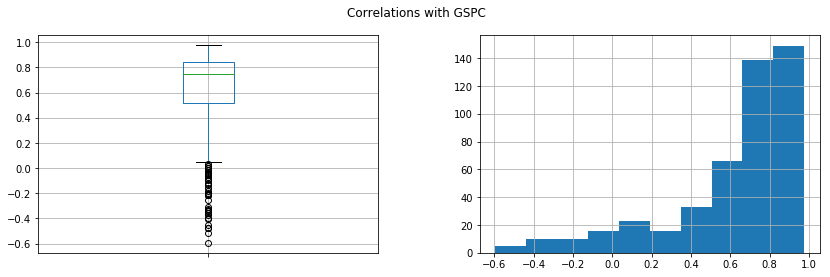

time: 977 ms


In [487]:
gspc_corrs = pd.DataFrame([math_utils.correlation(gspc.open[:len(x)], x.open)
                           for x in train_comp_prices], index=comp_metas.symbol, columns=[''])
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
gspc_corrs.boxplot(ax=axes[0])
gspc_corrs.hist(ax=axes[1])
fig.suptitle('Correlations with GSPC');

#### Correlation within Industry

In [11]:
ind_symbols, ind_resids, ind_prices, ind_orig_returns, ind_orig_prices, ind_resid_chars = calc_residuals([industry_name])


Are the characteristics the same as before? True
time: 1min 46s


In [18]:
ind_resid_chars.head()

,arima_p,arima_d,arima_q,unit_root,autocorr,normal_dist,heteroscedastic,breaks
APA,4,0,1,0,0,0,1,0
APC,1,0,1,0,0,0,1,0
BHI,4,0,1,0,0,0,0,0
CHK,0,0,2,0,0,0,1,0
COG,4,0,2,0,0,0,0,0


time: 194 ms


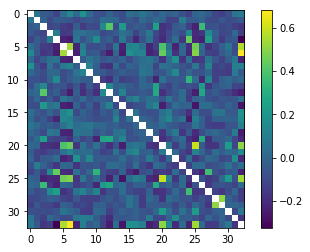

time: 874 ms


In [12]:
energy_correlations = calc_correlations(ind_symbols, ind_resids)
plt.imshow(energy_correlations)
plt.colorbar();

Correlate CVX and XOM:
Pearson's r = 0.68 (without preprocessing: 0.95)
Correlate COG and XOM:
Pearson's r = -0.32 (without preprocessing: 0.72)


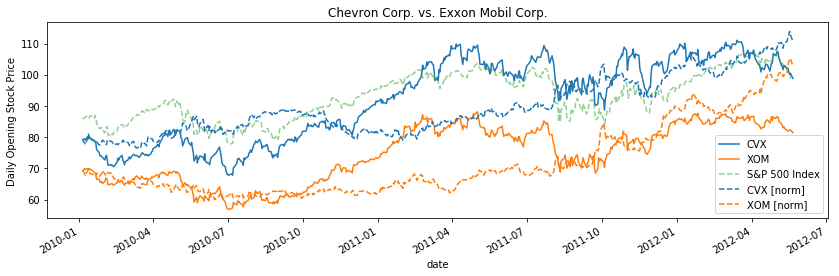

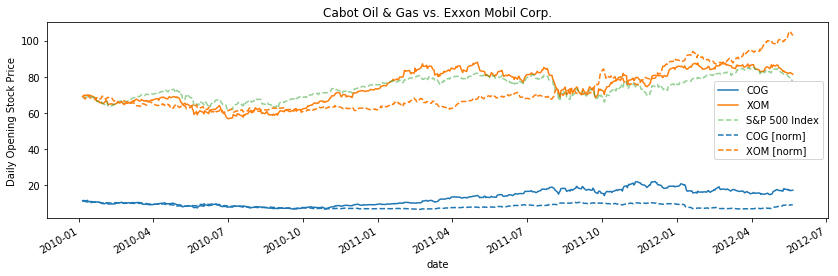

time: 1.39 s


In [497]:
stack = energy_correlations.stack()
pair = stack.idxmax()
# price_resids
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

pair = stack.idxmin()
plot.compare_industry_players(pair, energy_correlations.loc[pair], ind_prices, ind_orig_prices, gspc.open, securities)

Final correlation:  0.6922867603318198


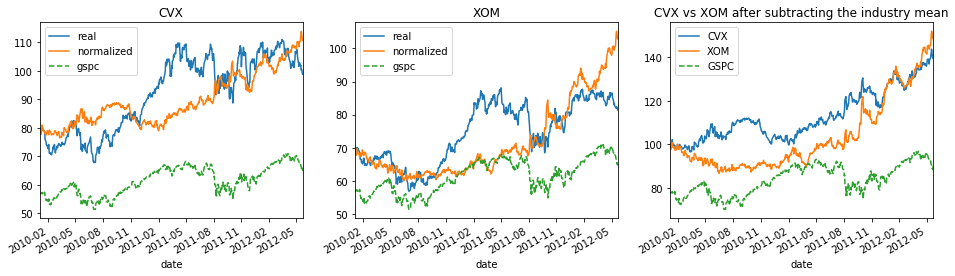

time: 1.34 s


In [499]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
a, b = stack.idxmax()
ind_orig_prices[a].plot(ax=axes[0], label='real', legend=True)
math_utils.abs_values(ind_prices[a], ind_orig_prices[a][0]).plot(ax=axes[0], label='normalized', legend=True, title=a)
(gspc.open / 20).plot(ls='--', ax=axes[0], label='gspc', legend=True)
axes[0].set_xlim((ind_prices[a].index[0], ind_prices[a].index[-1]))

ind_orig_prices[b].plot(ax=axes[1], label='real', legend=True)
math_utils.abs_values(ind_prices[b], ind_orig_prices[b][0]).plot(ax=axes[1], label='normalized', legend=True, title=b)
(gspc.open / 20).plot(ls='--', ax=axes[1], label='gspc', legend=True)
axes[1].set_xlim((ind_prices[b].index[0], ind_prices[b].index[-1]))

x = math_utils.abs_values(ind_prices[a])
y = math_utils.abs_values(ind_prices[b])
pd.concat([x, y], axis=1).plot(ax=axes[2], title=f'{a} vs {b} after subtracting the industry mean')
(gspc.open / gspc.open.max() * 100).plot(ls='--', ax=axes[2], label='GSPC', legend=True)
axes[2].set_xlim((x.index[0], x.index[-1]))
print('Final correlation: ', math_utils.correlation(*ind_prices.loc[:, stack.idxmax()].T.values))

#### Impact of Exogeneous Variables

Instead of subtracting the GSPC movement, one may consider GSPC (and industry mean) as exogeneous variables during the autoregression. The AR residuals (orange line) show that many GSPC movements almost vanished.

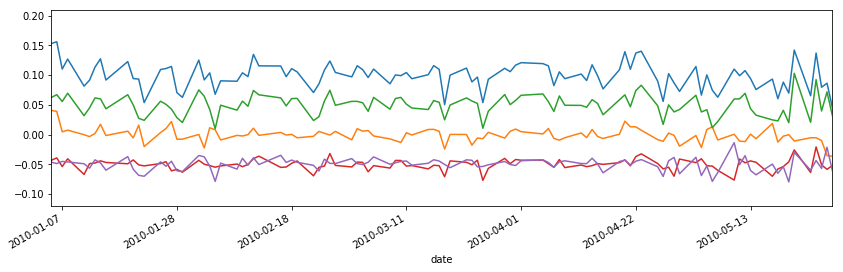

time: 519 ms


In [103]:
a, b = stack.idxmax()
ts = train_comp_prices[(comp_metas.symbol == a).idxmax()].boxcox  # industry_prices.loc[:, a]

mdl = smt.ARIMA(ts, exog=exog, order=(2, 0, 1)).fit(method='mle', trend='nc')

(ts + 0.1).plot(figsize=(14, 4))
plt.plot(mdl.resid)
plt.plot(mdl.fittedvalues + 0.05)
plt.plot(exog - 0.05)
plt.xlim((ts.index[0], ts.index[100]));

In [23]:
aic_values = regr.get_best_arima(ts, p=range(20), q=range(3, 4), exog=exog, debug=True)

Best AIC: -3844.2186 (worst: -3856.1580) | params: 19, 0, 3
time: 42min 20s


In [72]:
regr.investigate(mdl.resid, verbose=True);

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.7918
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.8500
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.09

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Heteroscedastiscity:
>Engle's ARCH (null = homosc.): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.9110
time: 310 ms


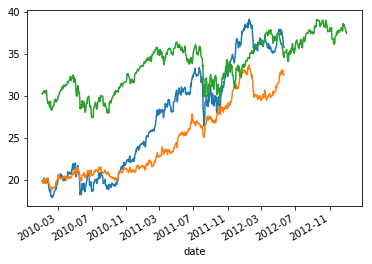

time: 487 ms


In [126]:
x.plot()
math_utils.abs_values(mdl.resid, x.iloc[0]).plot()
plt.plot(gspc.open / gspc.open.max() * x.max());

Outcome: I takes very long and the differences between the models are very small. So we keep the amount of coefficients low. Note that the significance is not present for less coeff.

#### Industry vs GSPC

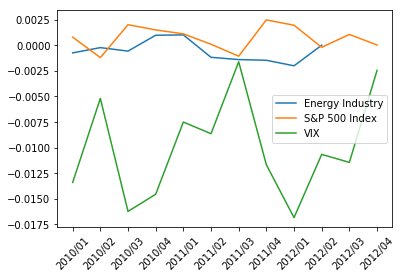

time: 502 ms


In [232]:
plot.plot_performance_quarterly(ind_prices, label='Energy Industry')
plot.plot_performance_quarterly(gspc.boxcox, label='S&P 500 Index')
plot.plot_performance_quarterly(vix.boxcox, label='VIX')
plt.legend();

### Graph

#### Setup

In [8]:
# https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/
def display_interactive_graph(G, output_file=None, pos=None, weight_threshold=0.5, title='correlation', layout_params={}, **kwargs):
    # Prepare graph data
    V = list(G.nodes())
    E = list(G.edges())
    weights = [x['weight'] for x in G.edges().values()]
    # To avoid subgraphs from drifting away: https://stackoverflow.com/a/54876985/4816930
    pos = (pos or nx.spring_layout)(G, **layout_params)

    V_enriched = [(x, securities.get_company_name(x), securities.get_industry(x), fundamentals.get_revenue(x)) for x in V]
    colors = plot.get_colors(np.unique([x[2] for x in V_enriched]))
    revenue_mean = np.nanmean([x[3] for x in V_enriched])
    revenue_max = np.nanmax([x[3] for x in V_enriched])

    nodes_dict = [{"id":n,
                   "title": f'{comp} ({industry})',
                   "color": colors[industry],
                   "border_width": 0.3,
                   "degree": ((revenue if not np.isnan(revenue) else revenue_mean) / revenue_max)**0.4 * 25,
                   "x":pos[n][0]*200,
                   "y":pos[n][1]*200} for (n, comp, industry, revenue) in V_enriched]
    node_map = dict(zip(V, range(len(V))))
    edges_dict = [{"id": f'{weights[i]:.2f}', "source": node_map[E[i][0]], "target": node_map[E[i][1]],
                   "width": 6 * weights[i]**2} for i in range(len(E))]  #  if weights[i] > weight_threshold
    return visJS_module.visjs_network(nodes_dict, edges_dict, graph_id=title, container=f'mynetwork{title}', node_icon_code="'undefined'",
                                      edge_width_field='width', edge_label_field='none', node_size_multiplier=2, node_font_size=8,
                                      graph_height=400, graph_width=800, export_network=bool(output_file), export_file=output_file, **kwargs)

def generate_graph(edges):
    edges = [(idx[0], idx[1], { 'weight': val }) for idx, val in edges.iteritems()]
    G = nx.Graph(title='number_of_shared_articles')
    G.add_weighted_edges_from([(x[0], x[1], x[2]['weight']) for x in edges])
    return G

def display_correlation_graph(correlations, pos=None, threshold=0.5, **kwargs):
    # Create and display grap
    if len(correlations.shape) == 2:
        edges = correlations.stack()
    else:
        edges = correlations
    edges = edges[edges >= threshold]
#     nodes = list(edges[edges >= threshold].index.remove_unused_levels().levels[0])
#     edges = correlations.loc[nodes, nodes].stack()
#     edges = edges[edges >= 0.2]
    G = generate_graph(edges)
    return display_interactive_graph(G, pos=pos, weight_threshold=threshold, **kwargs)

time: 177 ms


In [797]:
all_correlations.Residuals.shape

(217622,)

time: 189 ms


#### Generate for one industry

In [ ]:
display_correlation_graph(energy_correlations)

#### Generate for multiple industries

In [708]:
comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars = calc_residuals_v2(
    [all_industries[3], *all_industries[-2:]])

Are the characteristics the same as before? True
time: 1min 52s


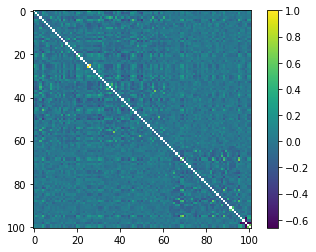

time: 8.83 s


In [709]:
correlations = calc_correlations(comp_symbols, comp_resids)
plt.imshow(correlations)
plt.colorbar();

In [ ]:
# Layouts: https://networkx.github.io/documentation/networkx-2.2/reference/drawing.html
display_correlation_graph(correlations, threshold=np.percentile(correlations.stack(), 99),
                          layout_params={'k': 0.3, 'iterations': 100, 'seed': 42})

#### All Companies

In [243]:
comp_symbols, comp_resids, comp_prices, comp_orig_returns, comp_orig_prices, comp_resid_chars = calc_residuals_v2(all_industries)
model_params = comp_resid_chars[['p', 'q', 'r', 's']]


Are the characteristics the same as before? True
time: 7min 5s


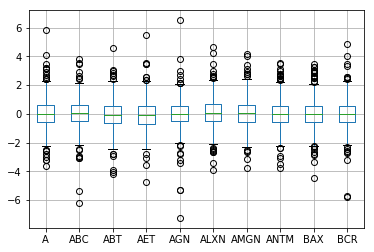

time: 518 ms


In [244]:
comp_resids.iloc[:, :10].boxplot()

##### Inspect model params
And plot showcases for ARMA and GARCH

     p    q    r    s
0  401  401  239  239
1   59   59  178  160
2    6    7   33   42
3    1    0   16   18
4    0    0    1    2
5    0    0    0    3
6    0    0    0    2
8    0    0    0    1


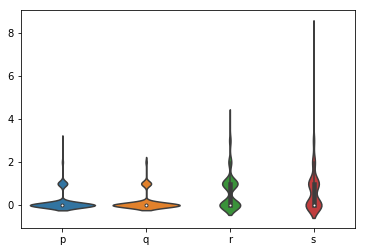

time: 409 ms


In [399]:
print(pd.concat([
    model_params.groupby('p').count().iloc[:, 0].rename('p'),
    model_params.groupby('q').count().iloc[:, 0].rename('q'),
    model_params.groupby('r').count().iloc[:, 0].rename('r'),
    model_params.groupby('s').count().iloc[:, 0].rename('s'),
], axis=1).fillna(0).astype(int))
sns.violinplot(data=model_params);

In [13]:
def plot_acf_pacf(x, sym, lags=10):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    smt.graphics.plot_acf(x, lags=lags, ax=axes[0], alpha=0.05)
    smt.graphics.plot_pacf(x, lags=lags, ax=axes[1], alpha=0.05)
    fig.suptitle(f'{securities.get_company_name(sym)} ({sym})')
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    return fig, axes

time: 169 ms


p    3
q    2
r    0
s    0
Name: NFX, dtype: object


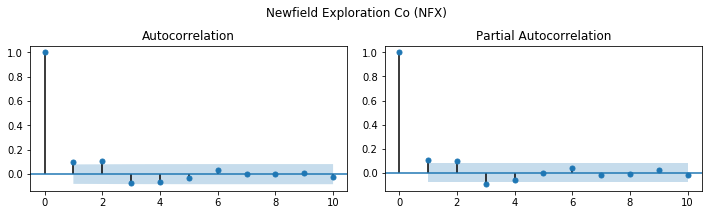

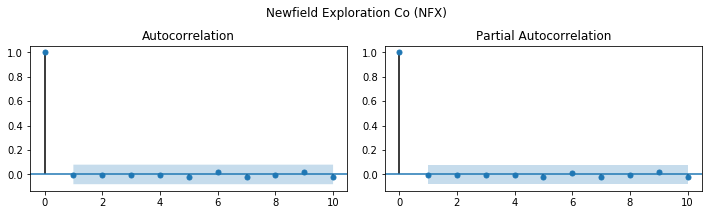

time: 1.54 s


In [21]:
sym = model_params[model_params.p == 3].index[0]
print(model_params.loc[sym])

fig, axes = plot_acf_pacf(comp_prices[sym], sym, 10)
fig.savefig(f'acf-{sym.lower()}-normed.pdf')

fig, axes = plot_acf_pacf(regr.model_ARMA(comp_prices[sym])[0], sym, 10)
fig.savefig(f'acf-{sym.lower()}-resid.pdf')

In [177]:
sym = model_params[model_params.s == 8].index[0]
resid = regr.model_ARMA(comp_prices[sym])[0]
std_resid = regr.model_GARCH(resid)[0]

time: 279 ms


p    1
q    1
r    1
s    8
Name: APC, dtype: object


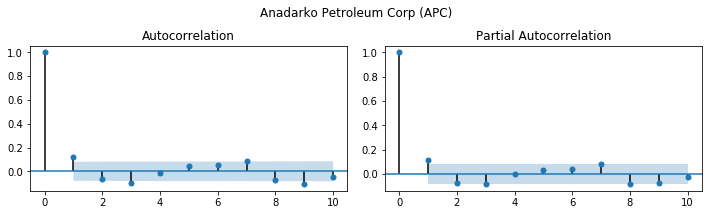

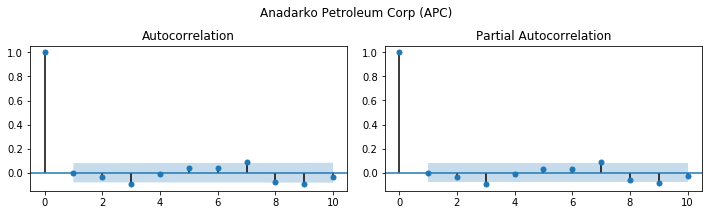

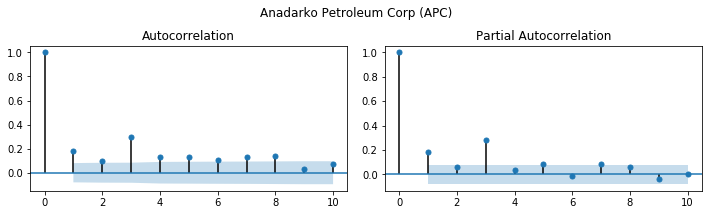

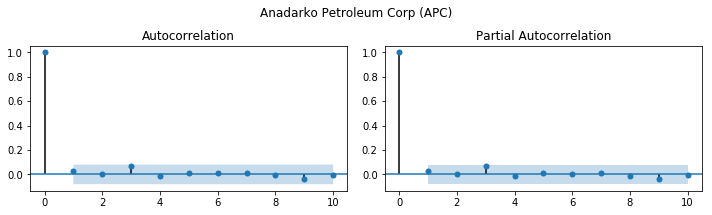

time: 2.01 s


In [22]:
sym = model_params[model_params.s == 8].index[0]
print(model_params.loc[sym])

fig, axes = plot_acf_pacf(comp_prices[sym], sym, 10)
fig.savefig(f'acf-{sym.lower()}-normed.pdf')

resid = regr.model_ARMA(comp_prices[sym])[0]
fig, axes = plot_acf_pacf(resid, sym, 10)
fig.savefig(f'acf-{sym.lower()}-resid.pdf')

fig, axes = plot_acf_pacf(resid**2, sym, 10)
fig.savefig(f'acf-{sym.lower()}-resid-sqr.pdf')

std_resid = regr.model_GARCH(resid)[0]
fig, axes = plot_acf_pacf(std_resid**2, sym, 10)
fig.savefig(f'acf-{sym.lower()}-std-resid-sqr.pdf')

##### Compare steps for correlation

In [9]:
print('Autocorrelated: ', comp_resid_chars[comp_resid_chars.autocorr != 0].index.tolist())
# Always KPSS, Can be fixed by taking greater parameters for ARIMA
print('Unit Root: ', comp_resid_chars[comp_resid_chars.unit_root != 0].index.tolist())
print('Amount of heteroscedastic: ', comp_resid_chars.groupby('heteroscedastic').count().loc[1][0])

Autocorrelated:  ['ILMN', 'LMT', 'TIF', 'IVZ', 'DOW', 'EQR', 'GGP']
Unit Root:  ['GILD', 'ILMN', 'PFE', 'PCAR', 'UPS', 'FOX', 'SIG', 'WYNN', 'ADBE', 'FSLR', 'INTC', 'MSFT', 'NFLX', 'STX', 'V', 'WDC', 'KMB', 'WMT', 'FE', 'MON', 'EQIX', 'COG', 'RRC', 'XOM', 'FTR']
Amount of heteroscedastic:  25
time: 204 ms


In [246]:
correlations_orig_prices = calc_correlations(comp_symbols, comp_orig_prices)  # .stack().astype(float)
correlations_orig_returns = calc_correlations(comp_symbols, comp_orig_returns)
correlations_normed = calc_correlations(comp_symbols, comp_prices)
correlations_resid = calc_correlations(comp_symbols, comp_resids)


time: 5min 24s


In [748]:
print('Significance for Pearson\'s r:')
for p_value, pearson_r in math_utils.r_critical_values.iteritems():
    print(f'> {p_value}: {pearson_r}')

Significance for Pearson's r:
> 0.1: 0.07
> 0.05: 0.09
> 0.01: 0.12
time: 204 ms


In [247]:
all_correlations = pd.concat([
    correlations_orig_prices.stack().rename('Price'),
    correlations_orig_returns.stack().rename('Return'),
    correlations_normed.stack().rename('Normalized'),
    correlations_resid.stack().rename('Residuals'),
], axis=1)

time: 343 ms


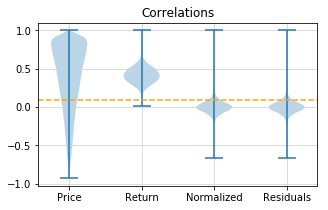

time: 6.85 s


In [248]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.violinplot(all_correlations.T)
ax.axhline(math_utils.r_critical_values[0.05], color='orange', linestyle='dashed')
ax.grid(True, color='lightgray')
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(all_correlations.columns.values)
ax.set_title('Correlations');
fig.savefig('steps-correlations.pdf')

In [356]:
# coor residuals - 99.9 Percentile: 0.3949
display_correlation_graph(correlations_resid.stack(), threshold=np.percentile(correlations_resid.stack(), 99.9),
                          layout_params={'k': 0.7, 'iterations': 200, 'seed': 42} , scaling_factor=1)
                          # output_file='graph-corr-resid-999-42')

time: 824 ms


Optional: export graph as PDF: https://stackoverflow.com/a/45863121/4816930

##### Collect examples for spurious regression

                   industry             name symbol
169  Information Technology       Fiserv Inc   FISV
405              Financials  Torchmark Corp.    TMK 



TypeError: set_title() got multiple values for argument 'label'

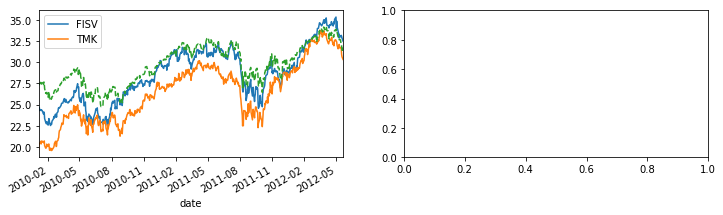

time: 768 ms


In [309]:
def plot_spurious_regression(a, b):
    print(comp_metas[comp_metas.symbol.isin([a, b])], '\n')
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    comp_orig_prices[[a, b]].plot(ax=axes[0])
    axes[0].plot(gspc.open / gspc.open.max() * comp_orig_prices[[a, b]].max().max(), '--')
    axes[0].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[0].set_title(f'Correlation: {correlations_orig_prices[a][b]:.2f}', label='GSPC')
    (comp_resids[[a, b]] + [0, 10]).plot(ax=axes[1])
    # axes[1].plot(gspc.open / gspc.open.max() * comp_orig_prices[[a, b]].max().max() - 100, '--')
    axes[1].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[1].set_title(f'Correlation: {correlations_resid[a][b]:.2f}')

l = (correlations_orig_prices.abs() - correlations_resid.abs()).abs().stack().sort_values(ascending=False)
for (a, b) in l[1000:1002].index:
    if a < b and a != 'GOOG':
        plot_spurious_regression(a, b)

                   industry             name symbol
169  Information Technology       Fiserv Inc   FISV
405              Financials  Torchmark Corp.    TMK 



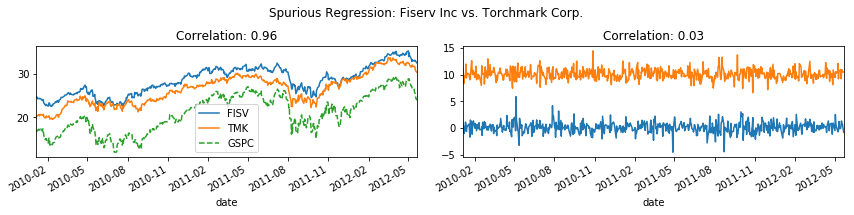

time: 1.36 s


In [315]:
def plot_spurious_regression(a, b):
    print(comp_metas[comp_metas.symbol.isin([a, b])], '\n')
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    comp_orig_prices[[a, b]].plot(ax=axes[0])
    vmin, vmax = comp_orig_prices[[a, b]].min().min(), comp_orig_prices[[a, b]].max().max()
    gmin, gmax = gspc.open.min(), gspc.open.max()
    axes[0].plot(12 + (gspc.open - gmin) / (gmax - gmin) * vmin, '--', label='GSPC')
    axes[0].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[0].set_title(f'Correlation: {correlations_orig_prices[a][b]:.2f}')
    axes[0].legend()
    (comp_resids[[a, b]] + [0, 10]).plot(ax=axes[1], legend=False)
    # axes[1].plot(gspc.open / gspc.open.max() * comp_orig_prices[[a, b]].max().max() - 100, '--')
    axes[1].set_xlim((comp_orig_prices[[a, b]].index.min(), comp_orig_prices[[a, b]].index.max()))
    axes[1].set_title(f'Correlation: {correlations_resid[a][b]:.2f}')
    fig.suptitle(f'Spurious Regression: {securities.get_company_name(a)} vs. {securities.get_company_name(b)}')
    fig.tight_layout()
    plt.subplots_adjust(top=0.8)
    return fig, axes

examples = [['ADI', 'TWX'], ['NEE', 'VTR'], ['ACN', 'CAT'], ['FISV', 'TMK']]
for a, b in examples[-1:]:
    fig, axes = plot_spurious_regression(a, b)
    fig.savefig(f'spurious-{a}-{b}.pdf')

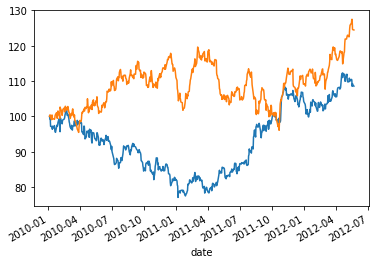

time: 625 ms


In [291]:
# correlations_orig_prices[a][b], correlations_resid[a][b], math_utils.correlation(comp_resids[a] * 0.01, comp_resids[b] * 0.01)
math_utils.abs_values(comp_resids[a] * 0.01).plot()
math_utils.abs_values(comp_resids[b] * 0.01).plot();

### Correlate with Cooccurrence

In [818]:
coocs = pd.read_csv('../data/preprocessed/occurrences/cooccurrences.csv', index_col=0).astype(float)
coocs.values[(np.arange(coocs.shape[0]),)*2] = np.nan
coocs = coocs.stack().astype(float)

time: 263 ms


In [849]:
in_same_industry = pd.Series(index=all_correlations.index)
industry_map = dict([(sym, securities.get_industry(sym)) for sym in comp_symbols])
for a, b in tqdm(all_correlations.index):
    in_same_industry[a, b] = industry_map[a] == industry_map[b]

time: 1min 2s


In [ ]:
merged = pd.concat([coocs.rename('Coocurrences'),
                    *[all_correlations[col] for col in all_correlations.columns],
                   in_same_industry.astype(int).rename('Same Industry')], axis=1).dropna()

In [ ]:
print('Pearson:')
print(utils.pandas_df_to_markdown_table(merged.corr().round(4)))
print('Spearman:')
print(utils.pandas_df_to_markdown_table(merged.corr(method='spearman').round(4)))
print('Kendall:')
print(utils.pandas_df_to_markdown_table(merged.corr(method='kendall').round(4)))

Pearson:

|      -        |   Coocurrences |   Price |   Return |   Normalized |   Residuals |   Same Industry |
|:--------------|---------------:|--------:|---------:|-------------:|------------:|----------------:|
| Coocurrences  |         1      |  0.0027 |   0.0588 |       0.0671 |      0.0691 |          0.069  |
| Price         |         0.0027 |  1      |   0.2604 |       0.1152 |      0.1152 |          0.0558 |
| Return        |         0.0588 |  0.2604 |   1      |       0.194  |      0.1958 |          0.2679 |
| Normalized    |         0.0671 |  0.1152 |   0.194  |       1      |      0.9944 |         -0.0624 |
| Residuals     |         0.0691 |  0.1152 |   0.1958 |       0.9944 |      1      |         -0.0623 |
| Same Industry |         0.069  |  0.0558 |   0.2679 |      -0.0624 |     -0.0623 |          1      |

Spearman:

|      -        |   Coocurrences |   Price |   Return |   Normalized |   Residuals |   Same Industry |
|:--------------|---------------:|--------:|---------:|-------------:|------------:|----------------:|
| Coocurrences  |         1      | -0.0518 |   0.0613 |       0.0324 |      0.0327 |          0.1477 |
| Price         |        -0.0518 |  1      |   0.2403 |       0.1181 |      0.1186 |          0.061  |
| Return        |         0.0613 |  0.2403 |   1      |       0.175  |      0.1756 |          0.2297 |
| Normalized    |         0.0324 |  0.1181 |   0.175  |       1      |      0.9926 |         -0.087  |
| Residuals     |         0.0327 |  0.1186 |   0.1756 |       0.9926 |      1      |         -0.0866 |
| Same Industry |         0.1477 |  0.061  |   0.2297 |      -0.087  |     -0.0866 |          1      |

Kendall:

|      -        |   Coocurrences |   Price |   Return |   Normalized |   Residuals |   Same Industry |
|:--------------|---------------:|--------:|---------:|-------------:|------------:|----------------:|
| Coocurrences  |         1      | -0.041  |   0.0485 |       0.0255 |      0.0258 |          0.1431 |
| Price         |        -0.041  |  1      |   0.1622 |       0.0786 |      0.0789 |          0.0498 |
| Return        |         0.0485 |  0.1622 |   1      |       0.1187 |      0.1191 |          0.1876 |
| Normalized    |         0.0255 |  0.0786 |   0.1187 |       1      |      0.9332 |         -0.071  |
| Residuals     |         0.0258 |  0.0789 |   0.1191 |       0.9332 |      1      |         -0.0707 |
| Same Industry |         0.1431 |  0.0498 |   0.1876 |      -0.071  |     -0.0707 |          1      |

Plot/Print diagonal:
- https://seaborn.pydata.org/examples/many_pairwise_correlations.html

### TO READ

- https://shishirshakya.blogspot.com/2015/06/the-todayamamoto-approach-to-granger.html
- On Plotting https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [ ]:
def inspect_forecast(model_fit, train, val):
    # multi-step out-of-sample forecast
    start_index = len(train)
    end_index = start_index + len(val) - 1
    ex_sample_forecast = model_fit.predict(start=start_index, end=end_index)
    ex_sample_forecast.index = val.index

    in_sample_forecast = model_fit.predict(len(train)-101, len(train)-1)

    plt.plot(train.iloc[-100:])
    plt.plot(val, 'b--', alpha=0.2)
    plt.plot(in_sample_forecast, color='orange', alpha=0.2)
    plt.plot(ex_sample_forecast, color='orange')

inspect_forecast(model_fit, train, val)